Here we will try to apply LmmNet to predict the cumulative cases to date as well as the fatalities. It is good to remind ourselves of the danger in such a forecasting, however:
* https://fivethirtyeight.com/features/coronavirus-case-counts-are-meaningless/

In [14]:
from lmmNet import lmmNet
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import pickle

# 1. Data Cleaning

We will use the data from Kaggle COVID-19 Forecasting Challenge https://www.kaggle.com/c/covid19-global-forecasting-week-3/

In [2]:
train_data = pd.read_csv("train.csv")

display(train_data)

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0
...,...,...,...,...,...,...
22333,32704,NaN,Zimbabwe,2020-03-30,7.0,1.0
22334,32705,NaN,Zimbabwe,2020-03-31,8.0,1.0
22335,32706,NaN,Zimbabwe,2020-04-01,8.0,1.0
22336,32707,NaN,Zimbabwe,2020-04-02,9.0,1.0


In [3]:
test_data = pd.read_csv('test.csv')

display(test_data)

,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-03-26
1,2,NaN,Afghanistan,2020-03-27
2,3,NaN,Afghanistan,2020-03-28
3,4,NaN,Afghanistan,2020-03-29
4,5,NaN,Afghanistan,2020-03-30
...,...,...,...,...
13153,13154,NaN,Zimbabwe,2020-05-03
13154,13155,NaN,Zimbabwe,2020-05-04
13155,13156,NaN,Zimbabwe,2020-05-05
13156,13157,NaN,Zimbabwe,2020-05-06


In [4]:
# first we prepare the data into a form that is suitable for analysis
country = 'Spain'
#population = 46749696.

country_df = train_data.copy()
country_df = country_df.loc[country_df['Country_Region']==country]

#uncomment if you need daily cases instead of cumulative cases
#country_df['ConfirmedDiff'] = country_df.ConfirmedCases.diff().fillna(0)

first_occurence = country_df.ConfirmedCases.to_numpy().nonzero()[0][0]

# now we need the day count since the first occurence
country_df = country_df[first_occurence:]
country_df['day_count'] = list(range(1,len(country_df)+1))

ydata = [(i, j) for i, j in zip(country_df.ConfirmedCases, country_df.Fatalities)] #infected cases
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

# initial conditions
x0 = [country_df.iloc[0].ConfirmedCases, country_df.iloc[0].Fatalities]

# 2. Training LmmNet

In [5]:
# mashing the data to suit LmmNet

time_points = xdata
covid19_data = ydata.reshape(1, ydata.shape[0], ydata.shape[1])
covid19_data.shape

(1, 63, 2)

In [6]:
hidden_layer_units = 256 # number of units for the hidden layer
M = 1 # number of steps
scheme = 'AM' # LMM scheme
h = time_points[1] - time_points[0]

model = lmmNet(h, covid19_data, M, scheme, hidden_layer_units)

In [7]:
N_Iter = 10000
model.train(N_Iter)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 0, Loss: 1.274e+07, Time: 0.17
Epoch: 100, Loss: 1.261e+07, Time: 7.05
Epoch: 200, Loss: 1.251e+07, Time: 13.63
Epoch: 300, Loss: 1.240e+07, Time: 20.07
Epoch: 400, Loss: 1.230e+07, Time: 26.90
Epoch: 500, Loss: 1.220e+07, Time: 32.67
Epoch: 600, Loss: 1.210e+07, Time: 40.43
Epoch: 700, Loss: 1.200e+07, Time: 46.72
Epoch: 800, Loss: 1.191e+07, Time: 53.15
Epoch: 900, Loss: 1.181e+07, Time: 59.38
Epoch: 1000, Loss: 1.172e+07, Time: 65.50
Epoch: 1100, Loss: 1.162e+07, Time: 70.70
Epoch: 1200, Loss:

In [8]:
def ml_f(x, t, model):
    """
    Define the derivatives learned by ML
    I think this is the best implementation, more robust than flatten()
    
    Args:
    x -- values for the current time point
    t -- time, dummy argument to conform with scipy's API
    model -- the learned ML model
    """
    return np.ravel(model.predict(x.reshape(1,-1)))

In [11]:
covid19_pred = odeint(ml_f, x0, time_points, args=(model,))

In [17]:
covid19 = {'data': covid19_data, 'pred':covid19_pred, 't':time_points}

with open('covid19.pkl', 'wb') as file:
    pickle.dump(covid19, file)

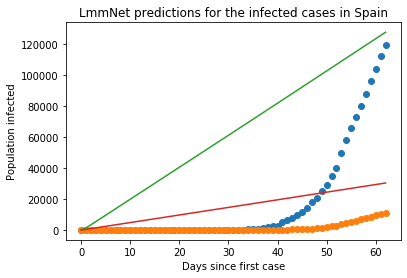

In [6]:
import matplotlib.pyplot as plt
import pickle

with open('covid19.pkl', 'rb') as file:
    covid19 = pickle.load(file)

covid19_data = covid19['data'].reshape(-1,2)
covid19_pred = covid19['pred']
time_points = range(len(covid19_data))
plt.plot(time_points, covid19_data, 'o')
plt.plot(time_points, covid19_pred)
plt.title("LmmNet predictions for the infected cases in " + 'Spain')
plt.ylabel("Population infected")
plt.xlabel("Days since first case")
plt.show()